In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from pandas import read_csv
from time import time 
import pickle
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AR
from xgboost import XGBRegressor

# Dummies

In [24]:
def dum_fest(df):
    cata = []; fes = read_csv("Excels/festivos.csv")
    for j in range(len(fes.index)):
            festiveDay = df.loc[(df.year==fes["Year"][j]) & (df.month==fes["Month"][j]) & (df.day==fes["Day"][j])].index.values.tolist()
            cata = cata + festiveDay

    df['fest'] = np.nan; df.fest = df.fest.fillna(pd.Series(-1, index=cata))
    df.fest = df.fest.fillna(0)
#     df = df.query("fest == 0")
#     df = df.drop("fest", axis = 1)
    return df

In [25]:
# lunes   martes-miercoles-jueves   viernes   sabado   domingo
def dum_dia(df):
    df.día_semana=df.día_semana.apply(lambda x: 1 if x==1 else (2 if x in [2,3,4] else (3 if x==5 else (4 if x==6 else 0))))
    df = pd.get_dummies(df, prefix=['d_sm'], columns=['día_semana'])
    df = df.drop("d_sm_0", axis = 1)
    return df

In [26]:
def dum_seas(df):
    df['seas'] = np.nan
    pr = df.query('day == 21 and month ==3').index
    vr = df.query('day == 21 and month == 6').index
    ot = df.query('day == 21 and month == 9').index
    inv= df.query('day == 21 and month == 12').index

    df.seas = df.seas.fillna(pd.Series(0, index=pr))
    df.seas = df.seas.fillna(pd.Series(1, index=vr))
    df.seas = df.seas.fillna(pd.Series(2, index=ot))
    df.seas = df.seas.fillna(pd.Series(3, index=inv))

    df.seas = df.seas.fillna(method= 'ffill')
    df.seas = df.seas.fillna(method= 'bfill')

    df = pd.get_dummies(df, prefix=['s_s'], columns=['seas'])
    df = df.drop("s_s_3.0", axis = 1)

    return df

In [27]:
#     Enero, Febrero, Marzo, Abril, Mayo, Junio, Julio, Agosto, Septiembre, Octubre, Diciembre
def dum_mensual(df):
    df = pd.get_dummies(df, prefix=['mon'], columns=['month'])
    df = df.drop("mon_12", axis = 1)
    return df

In [48]:
def fm1(i):
    global df
    df = pd.read_pickle("dflimpios.pkl")
    if i==0:
        df = dum_fest(df)
    if i==1:
        df = dum_dia(df)
    if i==2:
        df = dum_seas(df)
    if i==3:
        df = dum_mensual(df)
    if i==4:
        df = dum_mensual(dum_seas(dum_dia(dum_fest(df)))) 
    return df
fm1(1);

In [49]:
def sonas(): 
    return ["zona_{}".format(i+1) for i in range(26)]

# Funciones para regresión

In [50]:
# def get_zon_hor(h,z):
#     hora_n = df.query('hora == {}'.format(h))
#     zon_n = hora_n['{}'.format(z)]
#     return zon_n.values

In [51]:
def get_zon_hor(h,z):
    hora_n = df.query('hora == {}'.format(h))
    zon_n = hora_n['{}'.format(z)]
    # para quitar el dia que se va a predecir
#     zon_n.drop(zon_n.tail(365).index, inplace=True)
    # para quitar dias extremos
    zon_n = zon_n.reset_index(drop = True)
    zon_n = zon_n.drop(np.where((np.abs(stats.zscore(zon_n)))>4.5)[0])
    zon_n = zon_n.reset_index(drop = True)
    zon_n = zon_n[zon_n>1]
    # para quitar tendencia (no sirve por el momento)
#     zon_n = polynomial(zon_n, order=2)
    return zon_n

In [52]:
# def get_dums(h):
#     dem = ['hora',]# 'year', 'month']
#     zro =  sonas() #+dem
#     sin_zonas = df[df["hora"]==h]
#     sin_zonas=sin_zonas.reset_index()
#     sin_zonas = sin_zonas.drop(zro,  axis=1)
#     sin_zonas = sin_zonas.drop('index', axis=1)
#     return  sin_zonas

In [53]:
def get_dums(h, z):
    dem = ['hora',]# 'year', 'month']
    zro =  sonas() #+dem
    sin_zonas = df[df["hora"]==h]
    # para quitar los dias que se van a predecir
#     sin_zonas.drop(sin_zonas.tail(365).index,inplace=True)
    sin_zonas = sin_zonas.reset_index(drop = True)
    # para quitar dias extremos
    sin_zonas = sin_zonas.drop(np.where((np.abs(stats.zscore(sin_zonas[f"{z}"])))>4.5)[0])
    sin_zonas = sin_zonas.query(f"{z} > 1")
    sin_zonas = sin_zonas.reset_index(drop = True)
    #quitar zonas
    sin_zonas = sin_zonas.drop(zro,  axis=1)
    return  sin_zonas

In [250]:
def get_max_pts(h, z, armon):
    from  scipy import signal
    x = get_zon_hor(1, "zona_1")
    f, asd = signal.periodogram(x, fs=1)
    peaks, _ = find_peaks(asd, height=0)
    altura = _['peak_heights']
    fan = 1/(f[peaks])
    app = pd.DataFrame(altura, fan, columns=["altura_pk"]).sort_values(by="altura_pk",ascending=False).head(armon).iloc[armon-1:]
    return app;

In [82]:
def get_sc_coef(h, z, armon):
    X = pd.DataFrame()
    t = np.arange(len(get_zon_hor(h, z)))
    X["te"] = t 
    p = get_max_pts(h, z, armon)
    for i  in p.index:
        X["{}_sen".format(i)] = (np.sin((t*2*np.pi)/i))
        X["{}_cos".format(i)] = (np.cos((t*2*np.pi)/i))
    X["unos"] = 1
    X = X.drop("te", axis = 1)
    return X

In [68]:
def kron_conv(h, z, armon):
    dm1 = get_dums(h, z); dm2 = get_sc_coef(h, z, armon)
    d3 = pd.DataFrame(); kron = pd.DataFrame()
    for i in dm2.columns:
        d3 = dm1.multiply(dm2[f"{i}"], axis="index")
        d3.columns = [f"{j}_{i}" for j in dm1.columns]
        kron = pd.concat([kron, d3], axis = 1)
    X = kron.reset_index()
    X2 = pd.concat([X, dm1, dm2], sort = False, axis=1)
    X2 = X2.drop('index', axis = 1)
    X2 = X2.drop('unos', axis = 1)
    return X2

In [69]:
def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    ma = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return ma

In [80]:
def get_train_split_sick(X, y, dias):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = dias/len(y), shuffle = False)
    return X_train, X_test, y_train, y_test

In [71]:
def get_train_split_xgb(X, y, dias):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, shuffle = False)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = dias/len(y_test), shuffle = False)
    return X_train, X_test, X_val, y_train, y_test, y_val 

In [72]:
def regSck(h, z, armon, dias):
    y = np.array(get_zon_hor(h, z))
    X = kron_conv(h, z, armon)
    #Regressión con scikitlearn
    X_tr, X_te, y_tr, y_te = get_train_split_sick(X, y, dias)
    regress = LinearRegression(n_jobs = -1).fit(X_tr, y_tr)
    y_pred = regress.predict(X_te)
    m1 = MAPE(y_te, y_pred)
    
    return m1, y_pred

In [77]:
def regXGB(h, z, armon, dias):
    y = np.array(get_zon_hor(h, z))
    X = kron_conv(h, z, armon)
     #Regressión con XGBoost
    X_train, X_test, X_val, y_train, y_test, y_val = get_train_split_xgb(X, y, dias)
    regress2 = XGBRegressor(objective ='reg:squarederror', n_jobs=-1, max_depth=3, learning_rate=1.5, n_estimators=5)
    regress2.fit(X_train, y_train, eval_set=[(X,y),(X_val,y_val)], verbose=0, early_stopping_rounds=50)
    y_pred2 = regress2.predict(X_test)
    m2 = MAPE(y_test, y_pred2)
    
    return m2, y_pred2

In [78]:
def regAR(h, z):
    y = pd.Series(get_zon_hor(h, z))
    y_train, y_test = train_test_split(y, test_size = dias/len(y), shuffle = False)
    
    #Regresión con Autoregresión
    regresar = AR(y_train).fit()
    y_predico = regresar.predict(start=len(y_train), end=len(y_train) + len(y_test)-1, dynamic=False)
    m3 = MAPE(y_test, y_predico)
    return m3, y_predico

# Llamar datos

In [238]:
pkl_file = open('Excels/mapes_365_sextre.pkl', 'rb')
EAD = pickle.load(pkl_file)
pkl_file.close()
ED = EAD["mape"]

In [248]:
z = 7
EM = pd.DataFrame()
ED[f"zona_{z}"] = ED[f"zona_{z}"].rename(columns={'AR':'AR_-1_-1'})
EM[["model", "armon", "dli"]] = ED[f"zona_{z}"].idxmin(axis = 1).str.split('_',-1, expand=True)
EM[["armon", "dli"]] = EM[["armon", "dli"]].astype(int)#, errors = 'ignore')
EM = EM.replace(['Sck', 'XGB','AR'],[1,2, 3])

In [340]:
ED["zona_4"].idxmin(axis = 1)

1      Sck_2_2
2      XGB_0_0
3      Sck_2_2
4      Sck_2_2
5      Sck_2_2
6      Sck_2_5
7      Sck_2_0
8      Sck_2_0
9      XGB_2_3
10     XGB_0_3
11     XGB_0_3
12    AR_-1_-1
13    AR_-1_-1
14     Sck_2_1
15     Sck_2_4
16     Sck_2_4
17     Sck_2_4
18     Sck_2_4
19     XGB_0_4
20     XGB_0_2
21     XGB_0_1
22     Sck_2_1
23     Sck_2_4
24     XGB_0_4
dtype: object

## Guardar datos

In [254]:
def reg_specificas(dias=365):
    r = {}; y_p = {}
    for z in range(1, 27):
        EM = pd.DataFrame()
        ED[f"zona_{z}"] = ED[f"zona_{z}"].rename(columns={'AR':'AR_-1_-1'})
        EM[["model", "armon", "dli"]] = ED[f"zona_{z}"].idxmin(axis = 1).str.split('_', expand=True)
        EM[["armon", "dli"]] = EM[["armon", "dli"]].astype(int)
        EM = EM.replace(['Sck', 'XGB','AR'],[1,2, 3])
        r[f"zona_{z}"] = []; y_p[f"zona_{z}"] = []
        for h, a, armon, datos in zip(EM.index, EM["model"], EM["armon"], EM["dli"]):  

            if armon and datos == -1:
                r_, y_p_  = regAR(h, f"zona_{z}")
                r[f"zona_{z}"].append(r_); y_p[f"zona_{z}"].append(y_p_)
            if a == 1:
                r_, y_p_ = regSck(h, f"zona_{z}", armon, dias)
                r[f"zona_{z}"].append(r_); y_p[f"zona_{z}"].append(y_p_)

            if a == 2:
                r_, y_p_ = regXGB(h, f"zona_{z}", armon, dias)
                r[f"zona_{z}"].append(r_); y_p[f"zona_{z}"].append(y_p_)
    
    ro = pd.DataFrame(r, index = range(1, 25)); yo = pd.DataFrame(y_p, index = range(1, 25))
    FNE = {"mape": ro, "pred": yo}
    output = open(f'Modelos/modelos.pkl', 'wb'); pickle.dump(FNE, output); output.close()
    return FNE

In [255]:
FNE = reg_specificas(365)

C:\Users\alber\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\alber\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [320]:
FNE["pred"].loc[1, "zona_9"];

In [319]:
get_zon_hor(9, "zona_1").tail(365).values;

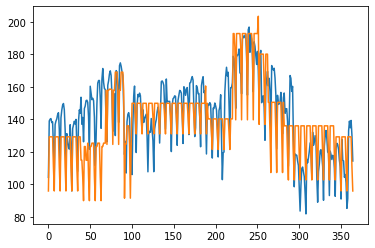

In [365]:
plt.plot(get_zon_hor(19,"zona_4").tail(365).values)
plt.plot(FNE["pred"].loc[19,"zona_4"])

In [ ]:
porque unos se ajustan mehor que otros

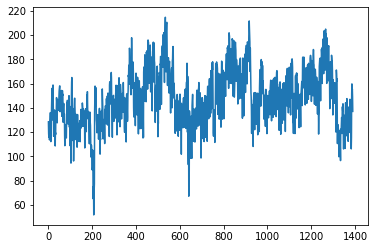

In [347]:
plt.plot(get_zon_hor(21, "zona_4"))